# SEIR-HCD Model

My codes refer some of the ideas from the following Kaggle source:

https://www.kaggle.com/anjum48/seir-hcd-model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy import stats
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import requests
import io

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Susceptible equation
def dS_dt(S, I, R_t, t_inf):
    return -(R_t / t_inf) * I * S


# Infected equation
def dI_dt(S, I, R_t, t_inf):
    return (R_t / t_inf) * I * S - (I / t_inf)


# Hospialized equation
def dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a):
    return ((1 - m_a) * (I / t_inf)) + ((1 - f_a) * C / t_crit) - (H / t_hosp)


# Critical equation
def dC_dt(H, C, t_hosp, t_crit, c_a):
    return (c_a * H / t_hosp) - (C / t_crit)


# Recovered equation
def dR_dt(I, H, t_inf, t_hosp, m_a, c_a):
    return (m_a * I / t_inf) + (1 - c_a) * (H / t_hosp)


# Deaths equation
def dD_dt(C, t_crit, f_a):
    return f_a * C / t_crit


def SEIR_HCD_model(t, y, R_t, t_inf=14, t_hosp=4, t_crit=14, m_a=0.8, c_a=0.1, f_a=0.3):
    if callable(R_t):
        reprod = R_t(t)
    else:
        reprod = R_t
        
    S, I, R, H, C, D = y

    S_out = dS_dt(S, I, reprod, t_inf)
    I_out = dI_dt(S, I, reprod, t_inf)
    R_out = dR_dt(I, H, t_inf, t_hosp, m_a, c_a)
    H_out = dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a)
    C_out = dC_dt(H, C, t_hosp, t_crit, c_a)
    D_out = dD_dt(C, t_crit, f_a)
    
    
    return [S_out, I_out, R_out, H_out, C_out, D_out]

# Load Data

In [3]:
train_path = 'data/train/'
output_path = 'data/output/'

In [4]:
harris_data_raw = pd.read_csv(train_path + 'harris_hosp_latest.csv')
harris_data_raw['Date'] = pd.to_datetime(harris_data_raw['Date'])
harris_data_raw.set_index('Date', inplace=True)
harris_data_raw

,Harris_GeneralBedUsing,Harris_CovidBed
Date,,
2020-03-19,2496,60
2020-03-20,2239,81
2020-03-21,1821,95
2020-03-22,1667,114
2020-03-23,3368,127
...,...,...
2020-07-04,6923,1703
2020-07-05,6531,1787
2020-07-06,7045,1795


In [5]:
# until 6-29
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
s = requests.get(url).content
data_raw = pd.read_csv(io.StringIO(s.decode('utf-8')))
data_raw = data_raw[data_raw['state']=='Texas']
data_raw = data_raw.rename(columns={'date': 'Date', 'cases': 'ConfirmedCases', 'deaths': 'Fatalities'})
data_raw['Date'] = pd.to_datetime(data_raw['Date'])

data_raw = data_raw[data_raw['Date']<='2020-06-29']

df = data_raw[['Date', 'county', 'ConfirmedCases', 'Fatalities']].set_index('Date')

harris_data_raw['Fatalities'] = df[df['county']=='Harris']['Fatalities']
harris_data_raw['ConfirmedCases'] = df[df['county']=='Harris']['ConfirmedCases']
harris_data_raw['county'] = 'Harris'
harris_data_raw

,Harris_GeneralBedUsing,Harris_CovidBed,Fatalities,ConfirmedCases,county
Date,,,,,
2020-03-19,2496,60,1.0,35.0,Harris
2020-03-20,2239,81,1.0,55.0,Harris
2020-03-21,1821,95,1.0,68.0,Harris
2020-03-22,1667,114,1.0,74.0,Harris
2020-03-23,3368,127,1.0,78.0,Harris
...,...,...,...,...,...
2020-07-04,6923,1703,NaN,NaN,Harris
2020-07-05,6531,1787,NaN,NaN,Harris
2020-07-06,7045,1795,NaN,NaN,Harris


In [6]:
for county in harris_data_raw['county'].unique():
    hosp_list = harris_data_raw[harris_data_raw['county']==county]['Harris_CovidBed'].rolling(window=7).mean()
    fatalities_list = harris_data_raw[harris_data_raw['county']==county]['Fatalities'].rolling(window=7).mean().cummax()
    harris_data_raw.loc[harris_data_raw['county']==county, 'Harris_CovidBed'] = hosp_list
    harris_data_raw.loc[harris_data_raw['county']==county, 'Fatalities'] = fatalities_list
    harris_data_raw.loc[harris_data_raw['county']==county] = harris_data_raw.loc[harris_data_raw['county']==county].query('Harris_CovidBed > 0')
    
harris_data_raw = harris_data_raw.dropna()
harris_data_raw

,Harris_GeneralBedUsing,Harris_CovidBed,Fatalities,ConfirmedCases,county
Date,,,,,
2020-03-25,4544.0,120.285714,1.000000,185.0,Harris
2020-03-26,3672.0,134.714286,1.142857,203.0,Harris
2020-03-27,4045.0,141.000000,1.285714,229.0,Harris
2020-03-28,3737.0,152.857143,1.571429,445.0,Harris
2020-03-29,3684.0,158.428571,2.000000,526.0,Harris
...,...,...,...,...,...
2020-06-25,7287.0,1000.142857,332.000000,27017.0,Harris
2020-06-26,7177.0,1060.571429,339.142857,28255.0,Harris
2020-06-27,6570.0,1128.000000,345.857143,29163.0,Harris


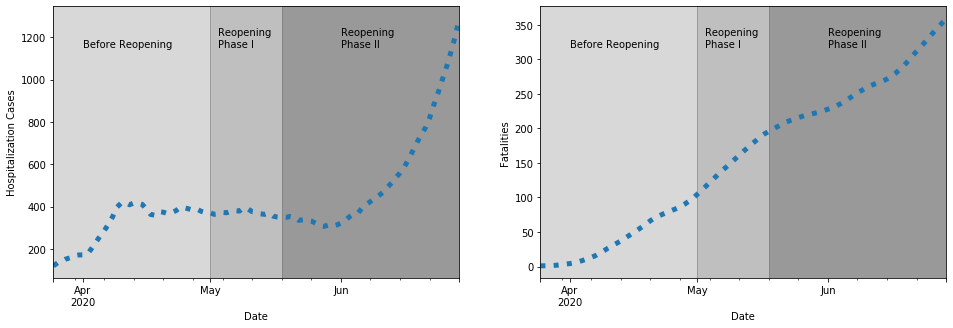

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    
ax1.set_ylabel('Hospitalization Cases')
ax2.set_ylabel('Fatalities')

ax1.axvspan(xmin=1,xmax=5, color='r', alpha=0.8)

harris_data_raw['Harris_CovidBed'].plot(label='Hospitalization Cases (train)', lw=5, linestyle=':', ax=ax1)

harris_data_raw['Fatalities'].plot(label='Fatalities (train)', lw=5, linestyle=':', ax=ax2)
for ax in [ax1, ax2]:
    ax.axvspan(xmin='2020-03-25',xmax='2020-05-01', color='grey', alpha=0.3)
    ax.axvspan(xmin='2020-05-01',xmax='2020-05-18', color='grey', alpha=0.5)
    ax.axvspan(xmin='2020-05-18',xmax='2020-06-29', color='grey', alpha=0.8)
    trans = ax.get_xaxis_transform()
    ax.text('2020-04-01', 0.85, 'Before Reopening', transform=trans)
    ax.text('2020-05-03', 0.85, 'Reopening\nPhase I', transform=trans)
    ax.text('2020-06-01', 0.85, 'Reopening\nPhase II', transform=trans)

plt.show()

In [8]:
harris_data_raw['Harris_CovidBed_14_days_ago'] = [0.0] * 14 + list(harris_data_raw['Harris_CovidBed'].iloc[:-14])
harris_data_raw['ConfirmedCases_14_days_ago'] = [0.0] * 14 + list(harris_data_raw['ConfirmedCases'].iloc[:-14])
harris_data_raw

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Harris_GeneralBedUsing,Harris_CovidBed,Fatalities,ConfirmedCases,county,Harris_CovidBed_14_days_ago,ConfirmedCases_14_days_ago
Date,,,,,,,
2020-03-25,4544.0,120.285714,1.000000,185.0,Harris,0.000000,0.0
2020-03-26,3672.0,134.714286,1.142857,203.0,Harris,0.000000,0.0
2020-03-27,4045.0,141.000000,1.285714,229.0,Harris,0.000000,0.0
2020-03-28,3737.0,152.857143,1.571429,445.0,Harris,0.000000,0.0
2020-03-29,3684.0,158.428571,2.000000,526.0,Harris,0.000000,0.0
...,...,...,...,...,...,...,...
2020-06-25,7287.0,1000.142857,332.000000,27017.0,Harris,468.142857,15864.0
2020-06-26,7177.0,1060.571429,339.142857,28255.0,Harris,492.000000,16188.0
2020-06-27,6570.0,1128.000000,345.857143,29163.0,Harris,511.571429,16568.0


In [9]:
harris_data_raw = harris_data_raw[harris_data_raw.index>='2020-05-01']
harris_data_raw

,Harris_GeneralBedUsing,Harris_CovidBed,Fatalities,ConfirmedCases,county,Harris_CovidBed_14_days_ago,ConfirmedCases_14_days_ago
Date,,,,,,,
2020-05-01,5308.0,372.428571,104.000000,6551.0,Harris,362.857143,4460.0
2020-05-02,3917.0,363.428571,109.714286,6708.0,Harris,359.285714,4653.0
2020-05-03,4664.0,365.714286,115.428571,6838.0,Harris,376.428571,4823.0
2020-05-04,5017.0,372.571429,121.428571,6967.0,Harris,373.571429,4977.0
2020-05-05,5350.0,371.142857,127.285714,7128.0,Harris,366.857143,5143.0
2020-05-06,5755.0,378.857143,133.142857,7244.0,Harris,371.285714,5211.0
2020-05-07,5515.0,380.857143,138.857143,7377.0,Harris,381.142857,5330.0
2020-05-08,5870.0,379.142857,144.285714,7594.0,Harris,396.714286,5482.0
2020-05-09,5224.0,394.285714,149.857143,7803.0,Harris,394.428571,5628.0


In [10]:
(harris_data_raw['Fatalities'] / harris_data_raw['ConfirmedCases_14_days_ago']).mean()

0.024116137127805193

In [11]:
DATE_BORDER = harris_data_raw.index.max()
# DATE_VALID_START = harris_data_raw.index.max() - pd.DateOffset(7)
DATE_VALID_START = harris_data_raw.index.max() - pd.DateOffset(6)
# DATE_VALID_START = '2020-06-22'

pop_info = pd.read_csv(train_path + 'covid_county_population_usafacts.csv')
pop_info['County Name'] = pop_info['County Name'].apply(lambda x: ' '.join(x.split(' ')[:-1]))
county_lookup = dict(zip(pop_info['County Name'], pop_info['population']))


train_full = harris_data_raw[harris_data_raw.index <= DATE_BORDER]

    
test = harris_data_raw[harris_data_raw.index >= DATE_VALID_START]
valid = train_full[train_full.index >= DATE_VALID_START]
train = train_full[train_full.index < DATE_VALID_START]

# # Split the test into public & private
test_public = test[test.index <= DATE_BORDER]
test_private = test[test.index > DATE_BORDER]


train_full.shape, train.shape, valid.shape, test.shape, test_public.shape, test_private.shape

((60, 7), (53, 7), (7, 7), (7, 7), (7, 7), (0, 7))

The function below evaluates a model with a constant `R` number as well as `t_hosp`, `t_crit`, `m`, `c`, `f`

In [12]:
OPTIM_DAYS = 100  # Number of days to use for the optimisation evaluation
intervention_phase_1 = 0
population_ratio_1 = 0.6038
population_ratio_2 = 0.417
phase_1_days = 17

In [13]:
def eval_model_decay(params, data, population, return_solution=False, forecast_days=0):
    R_0_low, R_0_high, t_hosp, t_crit, m, c, f, k_low, L_low, k_high, L_high  = params
    
    n_deaths = data['Fatalities'].iloc[0]
    n_recovered = data['Harris_CovidBed_14_days_ago'].iloc[0] * 60 * 0.98
    n_hosp = data['Harris_CovidBed'].iloc[0]
    n_crit = n_hosp * 0.5
    n_infected = n_hosp * 60
    
    # customize population ratio
    N_low_risk_1 = population * population_ratio_1
    N_high_risk_1  = population - N_low_risk_1
    N_low_risk_2 = population * population_ratio_2
    N_high_risk_2  = population - N_low_risk_2
    
    n_deaths_low_risk = n_deaths * population_ratio_1
    n_deaths_high_risk = n_deaths - n_deaths_low_risk
    n_recovered_low_risk = n_recovered * population_ratio_1
    n_recovered_high_risk = n_recovered - n_recovered_low_risk
    n_hosp_low_risk = n_hosp * population_ratio_1
    n_hosp_high_risk = n_hosp - n_hosp_low_risk
    n_crit_low_risk = n_crit * population_ratio_1
    n_crit_high_risk = n_crit - n_crit_low_risk
    n_infected_low_risk = n_infected * population_ratio_1
    n_infected_high_risk = n_infected - n_infected_low_risk
    
    max_days = len(data) + forecast_days
    
    # https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions   
    def time_varying_reproduction_low(t):
#         return R_0_low * (1 + ((t - intervention_phase_1)/L)**k)
        return R_0_low * (1 + ((t - intervention_phase_1)/L_low)**k_low)
    
    def time_varying_reproduction_high(t):
        return R_0_high * (1 + ((t - intervention_phase_1)/L_high)**k_high)
    
    # Low risk population curve-fitting: use trained params
    initial_state_low = [(N_low_risk_1-n_infected_low_risk-n_deaths_low_risk-n_recovered_low_risk-n_hosp_low_risk-n_crit_low_risk), \
                         n_infected_low_risk, n_recovered_low_risk, n_hosp_low_risk, \
                         n_crit_low_risk, n_deaths_low_risk]
    initial_state_low = [state / N_low_risk_1 for state in initial_state_low]
    args_low = (time_varying_reproduction_low, 11.5, t_hosp, t_crit, m, c, f)

    sol_low = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state_low, args=args_low, t_eval=np.arange(0, max_days))
    
    sus_low, inf_low, rec_low, hosp_low, crit_low, deaths_low = sol_low.y

    y_pred_hosp_low = np.append(np.clip(hosp_low, 0, np.inf)[:phase_1_days]*N_low_risk_1, \
                                np.clip(hosp_low, 0, np.inf)[phase_1_days:]*N_low_risk_2)
    y_pred_fat_low = np.append(np.clip(deaths_low, 0, np.inf)[:phase_1_days]*N_low_risk_1, \
                              np.clip(deaths_low, 0, np.inf)[phase_1_days:]*N_low_risk_2)
    
    
    # High risk population curve-fitting: train new params
    initial_state_high = [(N_high_risk_1-n_infected_high_risk-n_deaths_high_risk-n_recovered_high_risk-n_hosp_high_risk-n_crit_high_risk), \
                         n_infected_high_risk, n_recovered_high_risk, n_hosp_high_risk, \
                         n_crit_high_risk, n_deaths_high_risk]
    initial_state_high = [state / N_high_risk_1 for state in initial_state_high]
    args_high = (time_varying_reproduction_high, 11.5, t_hosp, t_crit, m, c, f)
    sol_high = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state_high, args=args_high, t_eval=np.arange(0, max_days))
    
    sus_high, inf_high, rec_high, hosp_high, crit_high, deaths_high = sol_high.y
    y_pred_hosp_high = np.append(np.clip(hosp_high, 0, np.inf)[:phase_1_days]*N_high_risk_1, \
                                 np.clip(hosp_high, 0, np.inf)[phase_1_days:]*N_high_risk_2)
    y_pred_fat_high = np.append(np.clip(deaths_high, 0, np.inf)[:phase_1_days]*N_high_risk_1, \
                                np.clip(deaths_high, 0, np.inf)[phase_1_days:]*N_high_risk_2)
    
    y_pred_cases = y_pred_hosp_low + y_pred_hosp_high
    y_true_cases = data['Harris_CovidBed'].values
    y_pred_fat = y_pred_fat_low + y_pred_fat_high
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(OPTIM_DAYS, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted

    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.sum([msle_cases, msle_fat]) / len(y_true_cases[-optim_days:])

#     msle_cases = mean_squared_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
#     msle_fat = mean_squared_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
#     msle_final = np.sum([msle_cases, msle_fat]) / len(y_true_cases[-optim_days:])

    
    msle_cases_no_weight = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:])
    msle_fat_no_weight = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:])
    mse_cases_no_weight = mean_squared_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:])
    mse_fat_no_weight = mean_squared_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:])
    
    print('MSLE training:', np.sum([msle_cases_no_weight, msle_fat_no_weight]) / len(y_true_cases[-optim_days:]))
    print('MSE training:', np.sum([mse_cases_no_weight, mse_fat_no_weight]) / len(y_true_cases[-optim_days:]))
    
    if return_solution:
        return msle_final, sol_low, sol_high
    else:
        return msle_final

In [14]:
def plot_model_results(y_pred, train_data, valid_data=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    ax1.set_ylabel('Hospitalization Cases')
    ax2.set_ylabel('Fatalities')
    
    train_data['Harris_CovidBed'].plot(label='Hospitalization Cases (train)', lw=5, linestyle=':', ax=ax1)
    
    # No reproduction number
#     ax3 = y_pred['R0_low'].plot(label='Reproduction number', color='c', linestyle='-', secondary_y=True, ax=ax1)
#     ax3 = y_pred['R0_high'].plot(label='Reproduction number', color='purple', linestyle='-', secondary_y=True, ax=ax1)
#     ax3.set_ylabel("Reproduction number", fontsize=10, color='c');
        
    train_data['Fatalities'].plot(label='Fatalities (train)', lw=5, linestyle=':', ax=ax2)
    
    if valid_data is not None:
        valid_data['Harris_CovidBed'].plot(label='Hospitalization Cases (valid)', color='r', linestyle=':', alpha=0.8, lw=5, ax=ax1)
        valid_data['Fatalities'].plot(label='Fatalities (valid)', color='r', linestyle=':', alpha=0.8, lw=5, ax=ax2)
    
    y_pred.loc[:, 'Harris_CovidBed'].plot(label='Modeled Cases', lw=5, color='grey', alpha=0.7, ax=ax1)
    y_pred.loc[:, 'Fatalities'].plot(label='Modeled Fatalities', lw=5, color='grey', alpha=0.7, ax=ax2)
    
    for ax in [ax1, ax2]:
        ax.axvspan(xmin='2020-05-01',xmax='2020-05-18', color='grey', alpha=0.3)
        ax.axvspan(xmin='2020-05-18',xmax='2020-06-29', color='grey', alpha=0.5)
        trans = ax.get_xaxis_transform()
        ax.text('2020-05-03', 0.6, 'Reopening\nPhase I', transform=trans)
        ax.text('2020-06-01', 0.6, 'Reopening\nPhase II', transform=trans)
    ax1.legend(loc='best')
    

The function below fits a SEIR-HCD model for each area, either using a constant R or a decayed R, whichever is better. If the total cases/1M pop is below 1, then the last value is used.

In [15]:
def fit_model_public(area_name, 
#                      initial_guess=[0.2, 4, 8, 0.95, 0.3, 0.1] + [0.5, 7, 14, 0.9, 0.6, 0.3] + [0.05, 36],
#                       bounds=(
#                               (0.01, 0.4), # R bounds -- low risk
#                               (0.4, 10), (2, 20), # transition time param bounds -- low risk
#                               (0.95, 1), (0.01, 0.4), (0.01, 1), # fraction time param bounds -- low risk
#                               (0.4, 20), # R bounds -- high risk
#                               (0.5, 10), (2, 20), # transition time param bounds -- high risk
#                               (0.8, 0.95), (0.4, 1), (0.2, 1), # fraction time param bounds -- high risk
#                               (0.1, 10), (1, 100)), # k, L
                     # optimal 1
#                     initial_guess=[0.2, 0.5] + [4, 14, 0.9, 0.5, 0.2] + [0.05, 6, 0.05, 6],
#                       bounds=(
#                               (0.01, 0.4), (0.4, 20),# R bounds
#                               (0.4, 10), (2, 20), # transition time param bounds
#                               (0.95, 1), (0.2, 1), (0.01, 1), # fraction time param bounds
#                               (0.01, 10), (1, 100), (0.01, 10), (1, 100)), # k, L
                      # optimal 2
#                       initial_guess=[0.2, 0.5] + [4, 14, 0.9, 0.5, 0.2] + [0.05, 45, 0.05, 45],
#                       bounds=(
#                               (0.01, 0.4), (0.4, 20),# R bounds
#                               (0.4, 10), (2, 20), # transition time param bounds
#                               (0.9, 1), (0.1, 1), (0.01, 1), # fraction time param bounds
#                               (0.01, 10), (1, 100), (0.01, 10), (1, 100)), # k, L
                     # optimal 3
#                       initial_guess=[0.2, 0.5] + [4, 14, 0.95, 0.5, 0.25] + [0.4, 6, 1, 6],
#                       bounds=(
#                               (0.01, 0.4), (0.4, 20),# R bounds
#                               (0.4, 10), (2, 20), # transition time param bounds
#                               (0.9, 1), (0.12, 1), (0.01, 1), # fraction time param bounds
#                               (0.01, 10), (0.1, 100), (0.01, 10), (0.1, 100)), # k, L
                     # optimal 4
#                       initial_guess=[0.1, 0.5] + [4, 14, 0.95, 0.4, 0.25] + [0.4, 6, 1, 6],
#                       bounds=(
#                               (0.01, 0.4), (0.4, 20),# R bounds
#                               (0.4, 10), (2, 20), # transition time param bounds
#                               (0.9, 1), (0.12, 1), (0.01, 1), # fraction time param bounds
#                               (0.01, 10), (0.1, 100), (0.01, 10), (0.1, 100)), # k, L
                     # optimal 5
#                      initial_guess=[0.2, 0.4] + [4, 14, 0.95, 0.3, 0.5] + [0.2, 6, 1, 6],
#                      bounds=(
#                               (0.01, 0.4), (0.4, 20),# R bounds
#                               (0.4, 10), (2, 20), # transition time param bounds
#                               (0.8, 1), (0.13, 1), (0.1, 1), # fraction time param bounds
#                               (0.01, 10), (0.1, 100), (0.01, 10), (0.1, 100)), # k, L
                     # optimal 6
#                      initial_guess=[0.2, 0.4] + [4, 14, 0.95, 0.3, 0.5] + [0.3, 6, 1, 4],
#                      bounds=(
#                               (0.01, 0.4), (0.4, 20),# R bounds
#                               (0.4, 10), (2, 20), # transition time param bounds
#                               (0.8, 1), (0.5, 1), (0.1, 1), # fraction time param bounds
#                               (0.01, 10), (0.1, 100), (0.01, 10), (0.1, 100)), # k, L
                     # optimal 7
#                      initial_guess=[0.2, 0.4] + [8, 10, 0.95, 0.5, 0.4] + [0.3, 50, 1, 10],
#                      bounds=(
#                               (0.01, 0.4), (0.4, 20),# R bounds
#                               (0.4, 10), (10, 20), # transition time param bounds
#                               (0.8, 1), (0.18, 1), (0.01, 1), # fraction time param bounds
#                               (0.1, 10), (0.1, 100), (0.01, 10), (0.1, 100)), # k, L
                     # optimal 8
#                      initial_guess=[0.2, 0.5] + [4, 14, 0.95, 0.1, 0.5] + [0.3, 50, 1.2, 10],
#                      bounds=(
#                               (0.01, 0.4), (0.4, 20),# R bounds
#                               (0.4, 10), (2, 20), # transition time param bounds
#                               (0.9, 1), (0.3, 1), (0.01, 1), # fraction time param bounds
#                               (0.1, 10), (0.1, 100), (0.01, 10), (0.1, 100)), # k, L
                     # optimal 9
#                      initial_guess=[0.2, 0.5] + [8, 14, 0.95, 0.3, 0.6] + [0.2, 50, 1, 10],
#                      bounds=(
#                               (0.1, 0.4), (0.4, 20),# R bounds
#                               (0.4, 10), (10, 20), # transition time param bounds
#                               (0.9, 1), (0.2, 1), (0.01, 1), # fraction time param bounds
#                               (0.1, 10), (0.1, 10), (0.01, 10), (0.1, 10)), # k, L
                     # optimal 10 == 100
#                      initial_guess=[0.2, 0.45] + [8, 14, 0.95, 0.3, 0.3] + [0.2, 50, 1, 10],
#                      bounds=(
#                               (0.1, 0.5), (0.4, 20),# R bounds
#                               (0.5, 10), (10, 20), # transition time param bounds
#                               (0.9, 1), (0.27, 1), (0.2, 1), # fraction time param bounds
#                               (0.1, 10), (0.1, 10), (0.01, 100), (0.1, 100)), # k, L
                     # optimal 10 == 75
#                      initial_guess=[0.2, 0.48] + [7, 14, 0.95, 0.3, 0.3] + [0.2, 50, 1, 10],
#                      bounds=(
#                               (0.1, 0.5), (0.4, 20),# R bounds
#                               (0.5, 10), (8, 20), # transition time param bounds
#                               (0.95, 1), (0.27, 1), (0.2, 1), # fraction time param bounds
#                               (0.1, 10), (0.1, 10), (0.01, 100), (0.1, 100)), # k, L
                     # optimal 11 == 29
#                      initial_guess=[0.2, 0.48] + [8, 14, 0.95, 0.3, 0.3] + [0.2, 50, 1, 10],
#                      bounds=(
#                               (0.1, 0.5), (0.4, 20),# R bounds
#                               (0.5, 10), (2, 20), # transition time param bounds
#                               (0.95, 1), (0.35, 1), (0.2, 1), # fraction time param bounds
#                               (0.1, 10), (0.1, 10), (0.01, 100), (0.1, 100)), # k, L
                     initial_guess=[0.2, 0.45] + [8, 14, 0.95, 0.3, 0.3] + [0.2, 50, 1, 10],
                     bounds=(
                              (0.1, 0.5), (0.4, 20),# R bounds
                              (0.5, 10), (2, 20), # transition time param bounds
                              (0.95, 1), (0.45, 1), (0.2, 1), # fraction time param bounds
                              (0.1, 10), (0.1, 10), (0.01, 100), (0.1, 100)), # k, L
                      make_plot=True):
    
    def time_varying_reproduction_low(t):
#         return R_0_low * (1 + ((t - intervention_phase_1)/L)**k)
        return R_0_low * (1 + ((t - intervention_phase_1)/L_low)**k_low)
    
    def time_varying_reproduction_high(t):
#         return R_0_high * (1 + ((t - intervention_phase_1)/L)**k)
        return R_0_high * (1 + ((t - intervention_phase_1)/L_low)**k_low)

    
    train_data = train[train['county']==area_name]    
    valid_data = valid[valid['county']==area_name].copy()   
    test_data = test_public[test_public['county']==area_name].copy()
    
    population = county_lookup[area_name]
    
    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, False),
                         method='L-BFGS-B', tol=10e-15)
#     res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
#                          args=(train_data, population, False),
#                          method='BFGS')
#     res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
#                          args=(train_data, population, False),
#                          method='SLSQP')
#     res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
#                          args=(train_data, population, False),
#                          method='TNC')
    
    dates_all = train_data.index.append(test_data.index)
    dates_val = train_data.index.append(valid_data.index)
    
    N_low_risk_1 = population * population_ratio_1
    N_high_risk_1  = population - N_low_risk_1
    N_low_risk_2 = population * population_ratio_2
    N_high_risk_2  = population - N_low_risk_2
    
    msle, sol_low, sol_high = eval_model_decay(res_decay.x, train_data, population, True, len(test_data))
    res = res_decay

    sus_low, inf_low, rec_low, hosp_low, crit_low, deaths_low = sol_low.y
    sus_high, inf_high, rec_high, hosp_high, crit_high, deaths_high = sol_high.y
    
    y_pred_hosp_low = np.append(np.clip(hosp_low, 0, np.inf)[:phase_1_days]*N_low_risk_1, \
                                np.clip(hosp_low, 0, np.inf)[phase_1_days:]*N_low_risk_2)
    y_pred_fat_low = np.append(np.clip(deaths_low, 0, np.inf)[:phase_1_days]*N_low_risk_1, \
                              np.clip(deaths_low, 0, np.inf)[phase_1_days:]*N_low_risk_2)
    y_pred_hosp_high = np.append(np.clip(hosp_high, 0, np.inf)[:phase_1_days]*N_high_risk_1, \
                                 np.clip(hosp_high, 0, np.inf)[phase_1_days:]*N_high_risk_2)
    y_pred_fat_high = np.append(np.clip(deaths_high, 0, np.inf)[:phase_1_days]*N_high_risk_1, \
                                np.clip(deaths_high, 0, np.inf)[phase_1_days:]*N_high_risk_2)
    
    
    t = np.arange(len(dates_all))
#     R_0_low, t_hosp_low, t_crit_low, m_low, c_low, f_low, R_0_high, t_hosp_high, t_crit_high, m_high, c_high, f_high, k, L  = res.x
    R_0_low, R_0_high, t_hosp, t_crit, m, c, f, k_low, L_low, k_high, L_high  = res.x
    R_t_low = pd.Series([time_varying_reproduction_low(t_i) for t_i in t], dates_all)
    R_t_high = pd.Series([time_varying_reproduction_high(t_i) for t_i in t], dates_all)
    
    y_pred = pd.DataFrame({
        'Harris_CovidBed': y_pred_hosp_low + y_pred_hosp_high,
        'Fatalities': y_pred_fat_low + y_pred_fat_high,
        'R0_low': R_t_low,
        'R0_high': R_t_high
#         'R': 0
    }, index=dates_all)
    
    y_pred_valid = y_pred.iloc[len(train_data): len(train_data)+len(valid_data)]
    y_true_valid = valid_data[['Harris_CovidBed', 'Fatalities']]
    print(y_true_valid)
    print(y_pred_valid)
    
    valid_msle_cases = mean_squared_log_error(y_true_valid['Harris_CovidBed'], y_pred_valid['Harris_CovidBed'])
    valid_msle_fat = mean_squared_log_error(y_true_valid['Fatalities'], y_pred_valid['Fatalities'])
    valid_msle = np.sum([valid_msle_cases, valid_msle_fat]) / len(y_true_valid['Fatalities'])
    
    valid_mse_cases = mean_squared_error(y_true_valid['Harris_CovidBed'], y_pred_valid['Harris_CovidBed'])
    valid_mse_fat = mean_squared_error(y_true_valid['Fatalities'], y_pred_valid['Fatalities'])
    valid_mse = np.sum([valid_mse_cases, valid_mse_fat])/len(y_true_valid['Fatalities'])
    
    
    if make_plot:
        print(f'Validation MSLE: {valid_msle:0.5f}')
        print(f'Validation MSE: {valid_mse:0.5f}')
#         print(f'R_0_low: {res.x[0]:0.3f}, t_hosp_low: {res.x[1]:0.3f}, t_crit_low: {res.x[2]:0.3f}, '
#               f'm_low: {res.x[3]:0.3f}, c_low: {res.x[4]:0.3f}, f_low: {res.x[5]:0.3f}, \n'
#               f'R_0_high: {res.x[6]:0.3f}, t_hosp_high: {res.x[7]:0.3f}, t_crit_high: {res.x[8]:0.3f}, '
#               f'm_high: {res.x[9]:0.3f}, c_high: {res.x[10]:0.3f}, f_high: {res.x[11]:0.3f}, k: {res.x[12]:0.3f}, L: {res.x[13]:0.3f}')
        print(f'R_0_low: {R_0_low:0.3f}, R_0_high: {R_0_high:0.3f}, \n'
              f't_hosp: {t_hosp:0.3f}, t_crit: {t_crit:0.3f}, m: {m:0.3f}, c: {c:0.3f}, f: {f:0.3f}, \n'
              f'k_low: {k_low:0.3f}, L_low: {L_low:0.3f}, k_high: {k_high:0.3f}, L_high: {L_high:0.3f}')
        plot_model_results(y_pred, train_data, valid_data)
        
    return res, y_true_valid, y_pred_valid, y_pred

MSLE training: 0.014049962821660893
MSE training: 11142.091304719937
MSLE training: 0.014049962945847727
MSE training: 11142.091385892783
MSLE training: 0.014049964266779128
MSE training: 11142.094225510487
MSLE training: 0.014049962841889502
MSE training: 11142.091329404298
MSLE training: 0.01404996281745058
MSE training: 11142.091303063027
MSLE training: 0.014049956960787025
MSE training: 11142.08486309167
MSLE training: 0.014049963087690746
MSE training: 11142.09143765077
MSLE training: 0.014049963001582353
MSE training: 11142.091274772163
MSLE training: 0.014049962818969476
MSE training: 11142.091305721053
MSLE training: 0.014049962821421378
MSE training: 11142.091304557482
MSLE training: 0.014049963164008295
MSE training: 11142.092183264307
MSLE training: 0.014049962780099682
MSE training: 11142.091214973714
MSLE training: 0.06403139317824637
MSE training: 2481.8786965006757
MSLE training: 0.06403139317369289
MSE training: 2481.8786964760257
MSLE training: 0.06403139318041585
MSE 

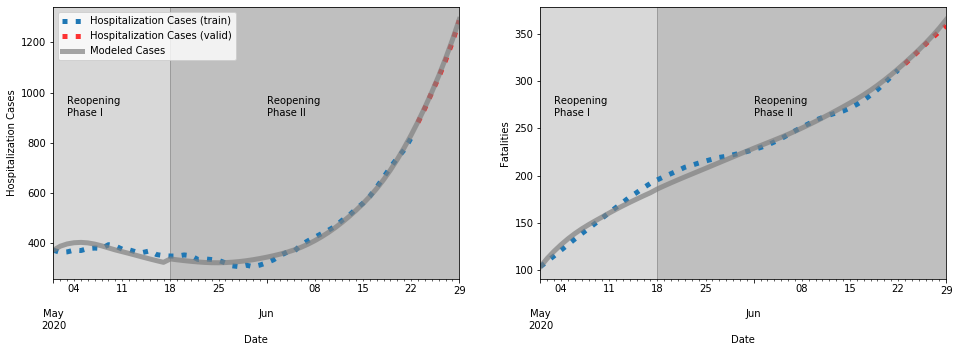

In [16]:
res, y_true_valid, y_pred_valid, y_pred = fit_model_public('Harris')

In [393]:
# y_pred.to_csv(output_path + 'predictions_v8_2.csv')

In [17]:
# mean_squared_error(y_pred['2020-05-01':'2020-05-17']['Harris_CovidBed'], train_full['2020-05-01':'2020-05-17']['Harris_CovidBed'])/len(y_pred['2020-05-01':'2020-05-17']['Fatalities'])
# mean_squared_error(y_pred['2020-05-17':'2020-06-22']['Harris_CovidBed'], train_full['2020-05-17':'2020-06-22']['Harris_CovidBed'])/len(y_pred['2020-05-17':'2020-06-22']['Fatalities'])
mean_squared_error(y_pred['2020-06-23':'2020-06-29']['Harris_CovidBed'], train_full['2020-06-23':'2020-06-29']['Harris_CovidBed'])/len(y_pred['2020-06-23':'2020-06-29']['Fatalities'])

4.009932537712422

In [18]:
# mean_squared_log_error(y_pred['2020-05-01':'2020-05-17']['Harris_CovidBed'], train_full['2020-05-01':'2020-05-17']['Harris_CovidBed'])/len(y_pred['2020-05-01':'2020-05-17']['Fatalities'])
# mean_squared_log_error(y_pred['2020-05-17':'2020-06-21']['Harris_CovidBed'], train_full['2020-05-17':'2020-06-21']['Harris_CovidBed'])/len(y_pred['2020-05-17':'2020-06-21']['Fatalities'])
mean_squared_log_error(y_pred['2020-06-23':'2020-06-29']['Harris_CovidBed'], train_full['2020-06-23':'2020-06-29']['Harris_CovidBed'])/len(y_pred['2020-06-23':'2020-06-29']['Fatalities'])

3.17875998108602e-06

In [19]:
# mean_squared_error(y_pred['2020-05-01':'2020-05-17']['Fatalities'], train_full['2020-05-01':'2020-05-17']['Fatalities'])/len(y_pred['2020-05-01':'2020-05-17']['Fatalities'])
# mean_squared_error(y_pred['2020-05-17':'2020-06-22']['Fatalities'], train_full['2020-05-17':'2020-06-22']['Fatalities'])/len(y_pred['2020-05-17':'2020-06-22']['Fatalities'])
mean_squared_error(y_pred['2020-06-23':'2020-06-29']['Fatalities'], train_full['2020-06-23':'2020-06-29']['Fatalities'])/len(y_pred['2020-06-23':'2020-06-29']['Fatalities'])

1.2536963888889956

In [20]:
# mean_squared_log_error(y_pred['2020-05-01':'2020-05-17']['Fatalities'], train_full['2020-05-01':'2020-05-17']['Fatalities'])/len(y_pred['2020-05-01':'2020-05-17']['Fatalities'])
# mean_squared_log_error(y_pred['2020-05-17':'2020-06-22']['Fatalities'], train_full['2020-05-17':'2020-06-22']['Fatalities'])/len(y_pred['2020-05-17':'2020-06-22']['Fatalities'])
mean_squared_log_error(y_pred['2020-06-23':'2020-06-29']['Fatalities'], train_full['2020-06-23':'2020-06-29']['Fatalities'])/len(y_pred['2020-06-23':'2020-06-29']['Fatalities'])

9.795805069579537e-06

# Counter-factual Analysis

In [21]:
R_0_low, R_0_high, t_hosp, t_crit, m, c, f, k_low, L_low, k_high, L_high = res.x

In [22]:
def plot_train_model(solution_low, solution_high, data, title='SEIR+HCD model'):
    sus_low, inf_low, rec_low, hosp_low, crit_low, deaths_low = sol_low.y
    sus_high, inf_high, rec_high, hosp_high, crit_high, deaths_high = sol_high.y

    y_pred_hosp_low = np.append(np.clip(hosp_low, 0, np.inf)[:phase_1_days]*N_low_risk_1, \
                                np.clip(hosp_low, 0, np.inf)[phase_1_days:]*N_low_risk_2)
    y_pred_fat_low = np.append(np.clip(deaths_low, 0, np.inf)[:phase_1_days]*N_low_risk_1, \
                              np.clip(deaths_low, 0, np.inf)[phase_1_days:]*N_low_risk_2)
    y_pred_hosp_high = np.append(np.clip(hosp_high, 0, np.inf)[:phase_1_days]*N_high_risk_1, \
                                 np.clip(hosp_high, 0, np.inf)[phase_1_days:]*N_high_risk_2)
    y_pred_fat_high = np.append(np.clip(deaths_high, 0, np.inf)[:phase_1_days]*N_high_risk_1, \
                                np.clip(deaths_high, 0, np.inf)[phase_1_days:]*N_high_risk_2)

    hosp = y_pred_hosp_low + y_pred_hosp_high
    death = y_pred_fat_low + y_pred_fat_high

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    fig.suptitle(title)
    
    ax1.plot(data['Harris_CovidBed'].values, label='Hospitalization cases (train)', lw=5, alpha=0.5)
    ax1.plot(hosp, 'tab:purple', label='Hospitalised');
    
    ax2.plot(data['Fatalities'].values, label='Fatalities cases (train)', lw=5, alpha=0.5)
    ax2.plot(death, 'tab:cyan', label='Deceased');
    
    ax1.set_xlabel("Days", fontsize=10);
    ax1.set_ylabel("Hospitalization Cases", fontsize=10);
    ax1.legend(loc='best');
     
    ax2.set_xlabel("Days", fontsize=10);
    ax2.set_ylabel("Fatalities", fontsize=10);

In [23]:
def plot_intervention_model(solution_low, solution_high, data, title='SEIR+HCD model'):
    sus_low, inf_low, rec_low, hosp_low, crit_low, deaths_low = sol_low.y
    y_pred_hosp_low = np.clip(hosp_low, 0, np.inf) * N_low_risk
    y_pred_fat_low = np.clip(deaths_low, 0, np.inf) * N_low_risk
    
    sus_high, inf_high, rec_high, hosp_high, crit_high, deaths_high = sol_high.y
    y_pred_hosp_high = np.clip(hosp_high, 0, np.inf) * N_high_risk
    y_pred_fat_high = np.clip(deaths_high, 0, np.inf) * N_high_risk


    hosp = y_pred_hosp_low + y_pred_hosp_high
    death = y_pred_fat_low + y_pred_fat_high

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    fig.suptitle(title)
    
    ax1.plot(data['Harris_CovidBed'].values, label='Hospitalization cases (train)', lw=5, alpha=0.5)
    ax1.plot(hosp, 'tab:purple', label='Hospitalised');
    
    ax2.plot(data['Fatalities'].values, label='Fatalities cases (train)', lw=5, alpha=0.5)
    ax2.plot(death, 'tab:cyan', label='Deceased');
    
    ax1.set_xlabel("Days", fontsize=10);
    ax1.set_ylabel("Hospitalization Cases", fontsize=10);
    ax1.legend(loc='best');
    
#     ax2.plot(cases, 'tab:red', label='Cases');    
    ax2.set_xlabel("Days", fontsize=10);
    ax2.set_ylabel("Fatalities", fontsize=10);

In [24]:
population_ratio = 0.417

In [25]:
population_ratio_1, population_ratio_2

(0.6038, 0.417)

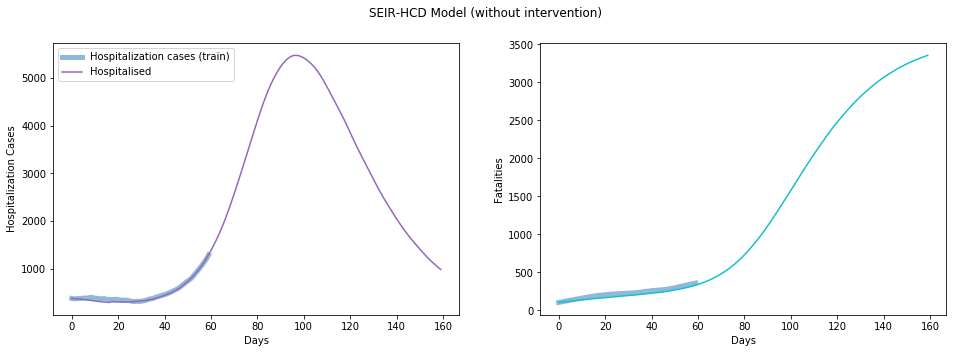

In [26]:
train_data = train_full[train_full['county']=='Harris']

N = county_lookup['Harris']

N_low_risk_1 = N * population_ratio_1
N_high_risk_1  = N - N_low_risk_1
N_low_risk_2 = N * population_ratio_2
N_high_risk_2  = N - N_low_risk_2

n_deaths = train_data['Fatalities'].iloc[0]
n_recovered = train_data['Harris_CovidBed_14_days_ago'].iloc[0] * 60 * 0.98
n_hosp = train_data['Harris_CovidBed'].iloc[0]
n_crit = n_hosp * 0.2
n_infected = n_hosp * 60

n_deaths_low_risk = n_deaths * population_ratio_1
n_deaths_high_risk = n_deaths - n_deaths_low_risk
n_recovered_low_risk = n_recovered * population_ratio_1
n_recovered_high_risk = n_recovered - n_recovered_low_risk
n_hosp_low_risk = n_hosp * population_ratio_1
n_hosp_high_risk = n_hosp - n_hosp_low_risk
n_crit_low_risk = n_crit * population_ratio_1
n_crit_high_risk = n_crit - n_crit_low_risk
n_infected_low_risk = n_infected * population_ratio_1
n_infected_high_risk = n_infected - n_infected_low_risk

max_days = len(train_data) + 100

def time_varying_reproduction_low(t):
    return R_0_low * (1 + ((t - intervention_phase_1)/L_low)**k_low)
    
def time_varying_reproduction_high(t):
    return R_0_high * (1 + ((t - intervention_phase_1)/L_high)**k_high)


# Low risk population
initial_state_low = [(N_low_risk_1-n_infected_low_risk-n_deaths_low_risk-n_recovered_low_risk-n_hosp_low_risk-n_crit_low_risk), \
                         n_infected_low_risk, n_recovered_low_risk, n_hosp_low_risk, \
                         n_crit_low_risk, n_deaths_low_risk]
initial_state_low = [state / N_low_risk_1 for state in initial_state_low]
args_low = (time_varying_reproduction_low, 11.5, t_hosp, t_crit, m, c, f)
sol_low = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state_low, args=args_low, t_eval=np.arange(0, max_days))

# High risk population
initial_state_high = [(N_high_risk_1-n_infected_high_risk-n_deaths_high_risk-n_recovered_high_risk-n_hosp_high_risk-n_crit_high_risk), \
                     n_infected_high_risk, n_recovered_high_risk, n_hosp_high_risk, \
                     n_crit_high_risk, n_deaths_high_risk]
initial_state_high = [state / N_high_risk_1 for state in initial_state_high]
args_high = (time_varying_reproduction_high, 11.5, t_hosp, t_crit, m, c, f)
sol_high = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state_high, args=args_high, t_eval=np.arange(0, max_days))


plot_train_model(sol_low, sol_high, train_data, 'SEIR-HCD Model (without intervention)')

2845905.6350000002 1867419.3649999998


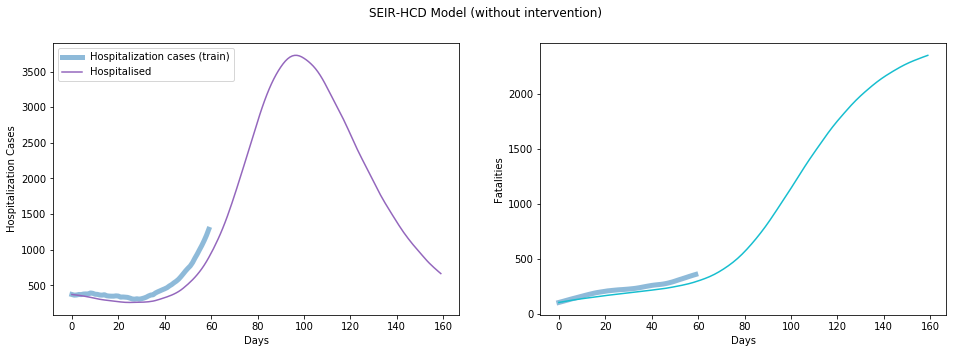

In [27]:
# population_ratio2 = 0.673
population_ratio2 = 0.6038

train_data = train_full[train_full['county']=='Harris']

N = county_lookup['Harris']
N_low_risk = N * population_ratio2
N_high_risk  = N - N_low_risk
print(N_low_risk, N_high_risk)

n_deaths = train_data['Fatalities'].iloc[0]
n_recovered = train_data['Harris_CovidBed_14_days_ago'].iloc[0] * 60 * 0.98
n_hosp = train_data['Harris_CovidBed'].iloc[0]
n_crit = n_hosp * 0.2
n_infected = n_hosp * 60

n_deaths_low_risk = n_deaths * population_ratio2
n_deaths_high_risk = n_deaths - n_deaths_low_risk
n_recovered_low_risk = n_recovered * population_ratio2
n_recovered_high_risk = n_recovered - n_recovered_low_risk
n_hosp_low_risk = n_hosp * population_ratio2
n_hosp_high_risk = n_hosp - n_hosp_low_risk
n_crit_low_risk = n_crit * population_ratio2
n_crit_high_risk = n_crit - n_crit_low_risk
n_infected_low_risk = n_infected * population_ratio2
n_infected_high_risk = n_infected - n_infected_low_risk

# max_days = len(train_data)
max_days = len(train_data) + 100

def time_varying_reproduction_low(t):
    return R_0_low * (1 + ((t - intervention_phase_1)/L_low)**k_low)
    
def time_varying_reproduction_high(t):
    return R_0_high * (1 + ((t - intervention_phase_1)/L_high)**k_high)

# Low risk population
initial_state_low = [(N_low_risk-n_infected_low_risk-n_deaths_low_risk-n_recovered_low_risk-n_hosp_low_risk-n_crit_low_risk), \
                         n_infected_low_risk, n_recovered_low_risk, n_hosp_low_risk, \
                         n_crit_low_risk, n_deaths_low_risk]
initial_state_low = [state / N_low_risk for state in initial_state_low]
args_low = (time_varying_reproduction_low, 11.5, t_hosp, t_crit, m, c, f)
sol_low2 = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state_low, args=args_low, t_eval=np.arange(0, max_days))

# High risk population
initial_state_high = [(N_high_risk-n_infected_high_risk-n_deaths_high_risk-n_recovered_high_risk-n_hosp_high_risk-n_crit_high_risk), \
                     n_infected_high_risk, n_recovered_high_risk, n_hosp_high_risk, \
                     n_crit_high_risk, n_deaths_high_risk]
initial_state_high = [state / N_high_risk for state in initial_state_high]
args_high = (time_varying_reproduction_high, 11.5, t_hosp, t_crit, m, c, f)
sol_high2 = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state_high, args=args_high, t_eval=np.arange(0, max_days))

plot_intervention_model(sol_low2, sol_high2, train_data, 'SEIR-HCD Model (without intervention)')

Text(0, 0.5, 'R0')

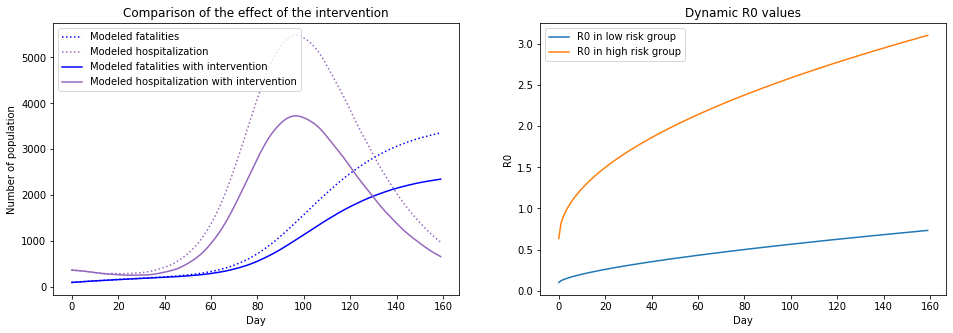

In [28]:
N_low_risk_1 = N * population_ratio_1
N_high_risk_1  = N - N_low_risk_1
N_low_risk_2 = N * population_ratio_2
N_high_risk_2  = N - N_low_risk_2

sus_low, inf_low, rec_low, hosp_low, crit_low, deaths_low = sol_low.y

sus_high, inf_high, rec_high, hosp_high, crit_high, deaths_high = sol_high.y
y_pred_hosp_low = np.append(np.clip(hosp_low, 0, np.inf)[:phase_1_days]*N_low_risk_1, \
                                np.clip(hosp_low, 0, np.inf)[phase_1_days:]*N_low_risk_2)
y_pred_fat_low = np.append(np.clip(deaths_low, 0, np.inf)[:phase_1_days]*N_low_risk_1, \
                          np.clip(deaths_low, 0, np.inf)[phase_1_days:]*N_low_risk_2)
y_pred_hosp_high = np.append(np.clip(hosp_high, 0, np.inf)[:phase_1_days]*N_high_risk_1, \
                             np.clip(hosp_high, 0, np.inf)[phase_1_days:]*N_high_risk_2)
y_pred_fat_high = np.append(np.clip(deaths_high, 0, np.inf)[:phase_1_days]*N_high_risk_1, \
                            np.clip(deaths_high, 0, np.inf)[phase_1_days:]*N_high_risk_2)

N_low_risk2 = N * population_ratio2
N_high_risk2  = N - N_low_risk2

sus_low2, inf_low2, rec_low2, hosp_low2, crit_low2, deaths_low2 = sol_low2.y
y_pred_hosp_low2 = np.clip(hosp_low2, 0, np.inf) * N_low_risk2
y_pred_fat_low2 = np.clip(deaths_low2, 0, np.inf) * N_low_risk2

sus_high2, inf_high2, rec_high2, hosp_high2, crit_high2, deaths_high2 = sol_high2.y
y_pred_hosp_high2 = np.clip(hosp_high2, 0, np.inf) * N_high_risk2
y_pred_fat_high2 = np.clip(deaths_high2, 0, np.inf) * N_high_risk2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

hosp = y_pred_hosp_low + y_pred_hosp_high
hosp2 = y_pred_hosp_low2 + y_pred_hosp_high2
deaths = y_pred_fat_low + y_pred_fat_high
deaths2 = y_pred_fat_low2 + y_pred_fat_high2

R_t_low = [time_varying_reproduction_low(t) for t in range(max_days)]
R_t_high = [time_varying_reproduction_high(t) for t in range(max_days)]

ax1.plot(deaths, 'b', label='Modeled fatalities', linestyle=':');
ax1.plot(hosp, 'tab:purple', label='Modeled hospitalization', linestyle=':');
ax1.plot(deaths2, 'b', label='Modeled fatalities with intervention');
ax1.plot(hosp2, 'tab:purple', label='Modeled hospitalization with intervention');

ax2.plot(R_t_low, label='R0 in low risk group')
ax2.plot(R_t_high, label='R0 in high risk group')

ax1.legend(loc='upper left')
ax1.set_title(f'Comparison of the effect of the intervention')
ax1.set_xlabel("Day", fontsize=10)
ax1.set_ylabel("Number of population", fontsize=10)

ax2.legend(loc='upper left')
ax2.set_title(f'Dynamic R0 values')
ax2.set_xlabel("Day", fontsize=10)
ax2.set_ylabel("R0", fontsize=10)